# Notebook 11: Spiking Neural Networks

Last week we used *Brian 2* to simulate individual neurons and explore their dynamical properties. This week we introduced spiking neural networks (SNNs) and how they can be used for biological simulation and machine learning problems. The goals of this notebook are:

+ Learn additional features of *Brian 2* that are useful in making SNNs.
+ How to create populations of neurons with heterogeneous dynamics.
+ Create and manipulate synapses between neurons.
+ Become familiar with liquid state machines.

In [1]:
!pip install brian2
!pip install brian2tools

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
%matplotlib inline
from brian2 import *
from brian2tools import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Simulating Many Neurons

It is easy to simulate large groups of neurons using *Brian 2*. We can add randomness to parameters of the neuron models to produce heterogeneous networks. Let's simulate 20 LIF neurons that have a random $\tau$ parameter between $0$ and $10ms$ and constant input $I(t) = 2$. The **rand()** function used in a string in *Brian 2* will produce a random number between $0$ and $1$ for each neuron in the network. We can also set up monitors for the **v** state variables, the spike times of each neuron, and the overall population firing rate.

In [3]:
start_scope()

# Network Parameters
sim_length = 30*ms
n_neurons = 20

# Model Parameters
I = 2
theta = 1

# Model Equations
eqs = '''
dv/dt = (-v+I)/tau:1
tau:second #assigning tau as a state variable allows us to easily access it for introducing randomness
'''

# Create Network
G = NeuronGroup(n_neurons,eqs, threshold = 'v > theta', reset = 'v = 0', method = 'euler')
G.v = 0
G.tau = '10*rand()*ms'

# Monitor Network States
M = StateMonitor(G,"v", record = True) #records state variable v for each neuron
spkM = SpikeMonitor(G) #records spike times of each neuron in network
Rates = PopulationRateMonitor(G) #records population firing rate

run(sim_length)

We can easily visualize the output of network by accessing our network monitors (the *brian_tools* package comes with many useful visualization features we will occasionally use).

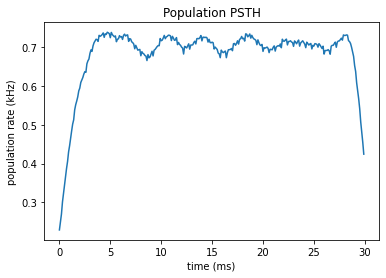

Text(0, 0.5, 'Neuron Index')

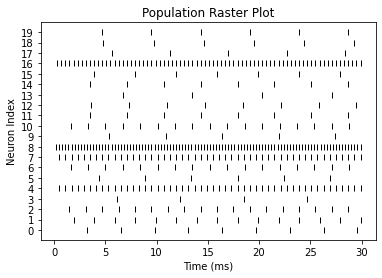

In [4]:
brian_plot(Rates)
plt.title("Population PSTH")
plt.show()

plt.plot(spkM.t/ms,spkM.i, '|',color = 'k')
plt.title("Population Raster Plot")
plt.yticks(np.arange(20))
plt.xlabel("Time (ms)")
plt.ylabel("Neuron Index")

Text(0, 0.5, 'V')

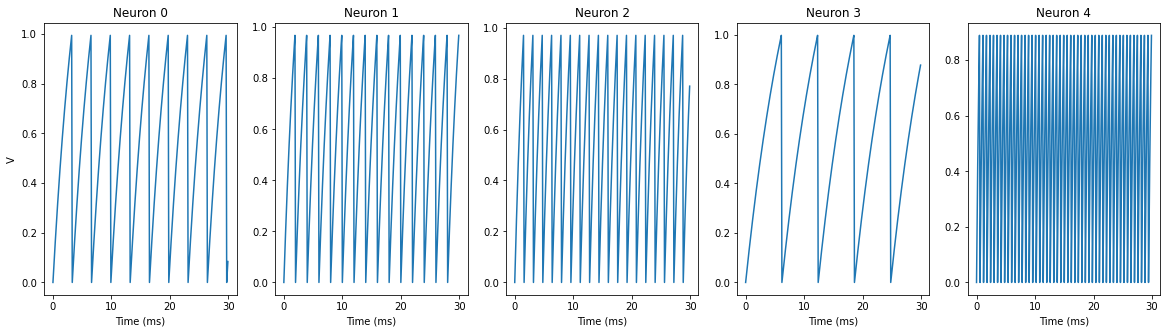

In [5]:
n_plot = 5
fig, ax = plt.subplots(nrows = 1, ncols = n_plot, figsize=(20,5))
for i in range(n_plot):
    ax[i].plot(M.t/ms,M.v[i])
    ax[i].set_xlabel("Time (ms)")
    ax[i].set_title(f"Neuron {i}")
ax[0].set_ylabel("V")

## Exercise 1

**A**. Create a network with the following properties:

+ 30 QIF neurons with a threshold of 40 and reset of 0.5
+ random $\tau$ between 5 and 10ms
+ random initial **v** condition between 0 and 1
+ constant input of 1

**B**. Plot the PSTH, rasters, and some **v** state variables of the network.

## Synapses

Creating synapses between the neurons in our network will allow the firing behavior of one neuron to be modulated by the firing of other neurons in the network (we can add an additonal monitor for the synapses). We will start out with a very basic synapse. When the pre-synaptic neuron fires, the voltage of the post-synaptic neuron will jump by the synaptic weight value between the two neurons. Let's simulate a network identical to the one in the first example, but now with a synapse connectivity matrix with the following properties:

+ the weights of each synapse will follow a Gaussian distribution with a mean of 0 (i.e., equal excitatory and inhibitory connections) and standard deviation of 0.1
+ each neuron will have a probability of 0.5 to be synapsed to any other neuron
+ no self-synapses

In [6]:
start_scope()
sim_length = 30*ms

#Model Parameters
n_neurons = 20
I = 2
theta = 1

#Model Equations
eqs = '''
dv/dt = (-v+I)/tau:1
tau:second
'''

#Create Network
G = NeuronGroup(n_neurons,eqs, threshold = 'v > theta', reset = 'v = 0', method = 'euler')
G.v = 0
G.tau = '10*rand()*ms'

#Create Synapses
S = Synapses(G,G,"w:1",on_pre='v += w') #create synapses from neuron group G to neuron group G
S.connect(p = 0.5, condition = 'i!=j') #connects synapses with optional conditons
S.w = np.random.normal(0,.1,size = len(S)) #random matrix with size equal to number of synapses needed

#Monitor Network State
M = StateMonitor(G,"v", record = True)
spkM = SpikeMonitor(G)
Rates = PopulationRateMonitor(G)
Syn_M = StateMonitor(S,'w',record = True) #monitor for synapses


run(sim_length)

WARNING    'i' is an internal variable of group 'synapses', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


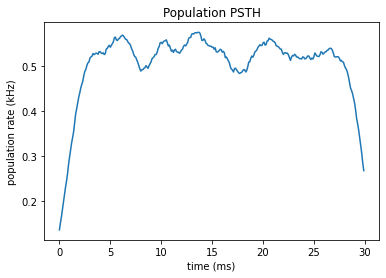

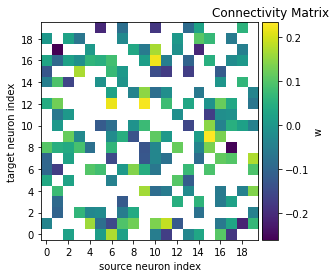

Text(0, 0.5, 'Neuron Index')

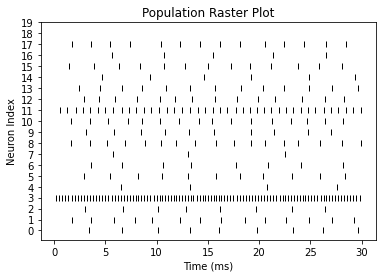

In [7]:
brian_plot(Rates)
plt.title("Population PSTH")
plt.show()

brian_plot(S.w)
plt.title("Connectivity Matrix")
plt.show()

plt.plot(spkM.t/ms,spkM.i, '|',color = 'k')
plt.title("Population Raster Plot")
plt.yticks(np.arange(20))
plt.xlabel("Time (ms)")
plt.ylabel("Neuron Index")

Text(0, 0.5, 'V')

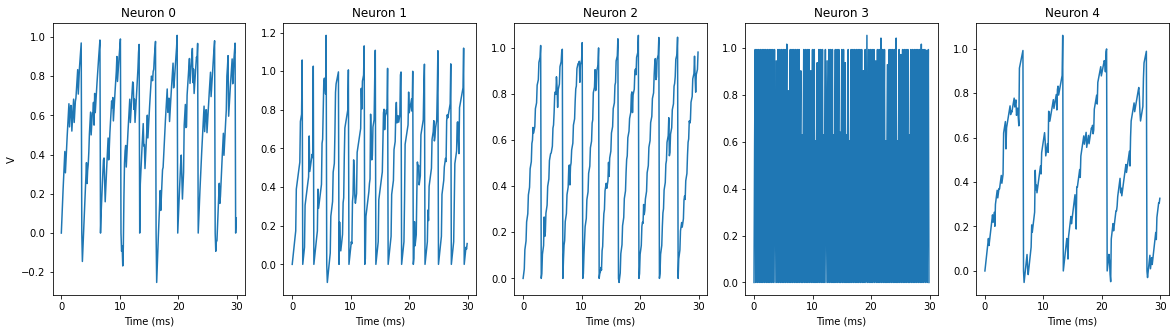

In [8]:
n_plot = 5
fig, ax = plt.subplots(nrows = 1, ncols = n_plot, figsize=(20,5))
for i in range(n_plot):
    ax[i].plot(M.t/ms,M.v[i])
    ax[i].set_xlabel("Time (ms)")
    ax[i].set_title(f"Neuron {i}")
ax[0].set_ylabel("V")

## Exercise 2

**A**. Create a network that is composed of two "areas", i.e. you will make two neuron groups (G1, G2). 

Let G1 have the following properties:

+ Composed of 20 LIF neurons with a constant input of 2.
+ A random $\tau$ between $0$ and $5ms$.
+ Each neuron in G1 synapses with every neuron in G2.
+ The weights of these synapses are normally distributed with a mean of 0 and a standard deviation of 2.

Let G2 have the following properties:

+ Composed of 40 LIF neurons (no direct input).
+ A random $\tau$ between $0$ and $10ms$.
+ Each neuron in G2 synapses with every neuron in G2 with a probability of 0.5.
+ Self-synapses are possible.
+ The weights of these synapses are normally distributed with a mean of 0 and standard deviation of 1.

**B**. Plot the PSTH, rasters, and synaptic connectivity matricies of G1 and G2.


## Spike-Timing-Dependent Plasticity

Synapses in the nervous system are dynamic and we may want our SNNs to reflect this property. A common model of Hebbian learning is spike-timing-dependent plasticity (STDP). If the pre-synaptic neuron fires before the post-synaptic neuron, the strength of that synapses increases. If the opposite occurs, the synapse will decrease in strength. A simple way to model STDP is with the following equations:

$\Delta w = \sum_{t_{pre}} \sum_{t_{post}} W(t_{post} - t_{pre})$

$ W(\Delta t)=   \left\{
\begin{array}{ll}
      A_{pre}exp(\frac{-\Delta t}{\tau_{pre}}) & \Delta t >0 \\
      A_{post}exp(\frac{-\Delta t}{\tau_{post}}) & \Delta t <0
\end{array} 
\right.$

where

+ $\Delta w$ is the change in synaptic strength
+ $t_{pre}$ and $t_{post}$ are the times of the pre- and post-synaptic spikes respectively
+ $\Delta t$ is $t_{post} - t_{pre}$
+ $W(\Delta t)$ is a function of the timing difference between the pre- and post-synatpic spikes, with parameters $A_{pre}, A_{post}, \tau_{pre}, \tau_{post}$

The way to algorithmically implement this version of STDP in *Brian 2* is not obvious and as a bonus exercise you should try and figure out why these equations and the algorithm below are equivalent.

Let's now simulate a network with STDP. We will use an additional parameter **wmax** to prevent our synapses from blowing up to arbitrarily high numbers. We will use a more complicated synaptic model than in the previous example. Each neuron will now have two inputs: $I_{ext}$ and $I_{syn}$. $I_{ext}$ will be an external input current and $I_{syn}$ will the the current due to synaptic inputs. A new state variable $I_{syn}$ will be added to the neuron equations and will be modeled as an exponential decay. A post-synaptic neuron receiving a spike will increase its $I_{syn}$ by an amount equal to the synapse weight, and this current will decay with parameter $\tau_{syn}$. Each synapse will also have a delay associated with it (you can imagine this is modeling some notion of distance between neurons in the network).

Additonally, let's demonstrate how to have a more complicated input structure into our network. The previous notebook gave you code for a *TimedArray* where you can give a neuron a time-varying input current. We can also use a *TimedArray* to give every neuron in the network a unique time-varying input. In the below code, each neuron receives a sine wave input with a random phase. Each sine wave has Gaussian random noise added to it. We chose a signal length of $5000$ since our simulation length is $500ms$ and our simulation is running at a default time resolution of $0.1ms$.

In [9]:
start_scope()

# Simulation Parameters
n_neurons = 20
sim_length = 500*ms

# STDP Parameters
taupre = taupost = 5*ms
wmax = 0.01
Apre = 0.1
Apost = -0.1

#Input Signal
I_ext = []
for m in range(n_neurons):
    random_phase = np.random.normal(0,2*pi,size = 1)
    I_signal = 2*np.sin(np.arange(5000)*0.01+random_phase)
    I_noise = np.random.normal(0,0.5,size = len(I_signal))
    I_ext.append(I_signal+I_noise)
I_ext = TimedArray(np.array(I_ext).T,dt = 0.1*ms) 

# Model Parameters
theta = 1
tau_syn = 2*ms

# Model Equations
eqs = '''
dv/dt = (-v+I_ext(t,i)+I_syn)/tau:1 #notice new index i in the I_ext state variable, this iterates over each neuron
dI_syn/dt = -I_syn/tau_syn:1
tau:second
'''

# Create Network
G = NeuronGroup(n_neurons,eqs, threshold = 'v > theta', reset = 'v = 0', method = 'euler')
G.v = 0
G.tau = '(rand()*5+5)*ms'

# Create Synapses
S = Synapses(G,G,
            '''
            w:1
            dapre/dt = -apre/taupre:1 (event-driven)
            dapost/dt = -apost/taupost:1 (event-driven)
            ''',
            on_pre= '''
            I_syn += w
            apre += Apre
            w = clip(w+apost, -wmax, 0)
            ''',
            on_post = '''
            apost += Apost
            w = clip(w+apre, 0, wmax )
            ''',
            method = 'linear')
S.connect(condition = 'i!=j')
S.w = np.random.normal(0,.1,size = len(S))
S.delay = '(rand()*2)*ms' #random delay in each synapse

# Monitor Network States
M = StateMonitor(G,"v", record = True)
spkM = SpikeMonitor(G)
Rates = PopulationRateMonitor(G)
Syn_M = StateMonitor(S,'w',record = True)


run(sim_length)


WARNING    'i' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


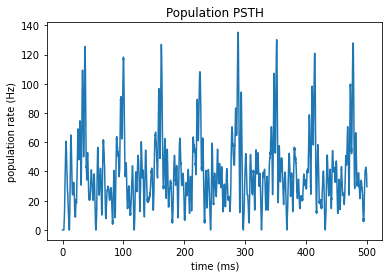

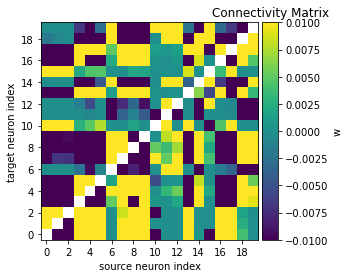

Text(0, 0.5, 'Neuron Index')

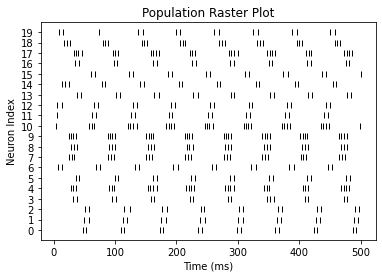

In [10]:
brian_plot(Rates)
plt.title("Population PSTH")
plt.show()

brian_plot(S.w)
plt.title("Connectivity Matrix")
plt.show()

plt.plot(spkM.t/ms,spkM.i, '|',color = 'k')
plt.title("Population Raster Plot")
plt.yticks(np.arange(20))
plt.xlabel("Time (ms)")
plt.ylabel("Neuron Index")

The connectivity matrix plotted above is the final state of the network synapses. We can access the connectivity matrix at every time point by indexing the synapse monitor that we created. Below shows an alternative way to plot the connectivity matrix of the network, as well as plotting the matrix at different time points in the simulation.

In [11]:
W_int = np.zeros((n_neurons,n_neurons)) #initial connectivity matrix
W_middle = np.zeros((n_neurons,n_neurons)) #halfway through the simulation
W_final = np.zeros((n_neurons,n_neurons)) #final connectivity matrix

W_int[S.i,S.j] = Syn_M.w[:,0]
W_middle[S.i,S.j] = Syn_M.w[:,2500]
W_final[S.i,S.j] = Syn_M.w[:,-1]

Text(0, 0.5, 'Target Neuron Index')

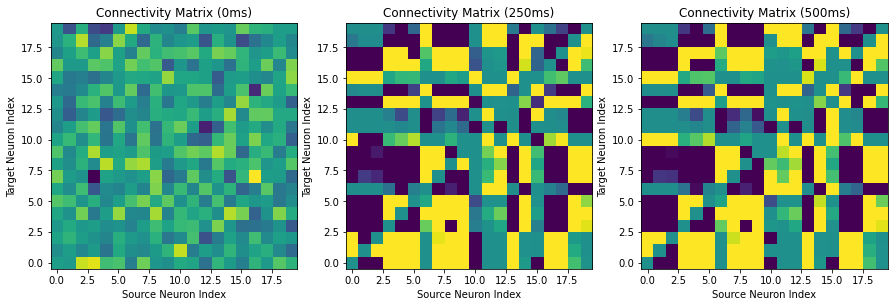

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(15,5))
ax[0].imshow(W_int.T,origin='lower')
ax[0].set_title("Connectivity Matrix (0ms)")
ax[0].set_xlabel("Source Neuron Index")
ax[0].set_ylabel("Target Neuron Index")


ax[1].imshow(W_middle.T,origin='lower')
ax[1].set_title("Connectivity Matrix (250ms)")
ax[1].set_xlabel("Source Neuron Index")
ax[1].set_ylabel("Target Neuron Index")

ax[2].imshow(W_final.T,origin='lower')
ax[2].set_title("Connectivity Matrix (500ms)")
ax[2].set_xlabel("Source Neuron Index")
ax[2].set_ylabel("Target Neuron Index")

## Exercise 3

**A**. Create a new network identical to the one above, but with the following changes:

+ Increase the number of neurons to 40.
+ Choose a new time-varying input function for the network. Add Gaussian noise so each neuron is getting a unique input. 

*Hint*: You may need to adjust the STDP parameters to prevent your network for blowing up or becoming silent.

**B**. Plot the PSTH, rasters, and the synaptic connectivity matricies at times $0$, $100$, $300$, and $500ms$.

## Liquid State Machines

Training SNNs is often difficult since the outputs of most spiking models of neurons are not differentiable. One easy method is to use a liquid state machine (LSM) architecture. An LSM is a reservoir computing framework where a collection (i.e., reservoir) of neurons are randomly connected and a linear model is trained on the output of the neurons in response to some input. A simple example would be to reconstruct the input into the reservoir based on the responses of the neurons (i.e., a decoding model).

For a univariate stimulus $s(t)$ and neuron responses $r(t)$, a linear decoding model can be specificed by the following equation:

$s(t) = \sum_{i = 0}^{N} \sum_{k = 0}^{\tau} r_i(t+k)w_i(k)$

where, 

+ $N$ is the number of neurons in the reservoir
+ $\tau$ is some time horizon for hypothesized stimulus saliency (e.g., 50ms)
+ $r_i(t)$ is the response of neuron $i$ at time $t$
+ $w_i(k)$ is the decoder weight for neuron $i$ at time lag $k$

For example, suppose we had a stimulus with a duration of 3 time units and recorded from two neurons. The decoding model could then be written in the matrix form (with $\tau = 2$):

$\begin{bmatrix}s(0)\\s(1)\\s(2)\end{bmatrix} = $
$\begin{bmatrix} r_1(0) & r_1(1) & r_1(2) & r_2(0) & r_2(1) & r_2(2)\\ r_1(2) & r_1(3) & r_1(4) & r_2(2) & r_2(3) & r_2(4)\\ r_1(3) & r_1(4) & r_1(5) & r_2(3) & r_2(4) & r_2(5)\end{bmatrix}$
$\begin{bmatrix}w_1(0)\\w_1(1)\\w_1(2)\\w_2(0)\\w_2(1)\\w_2(2)\end{bmatrix}$

I encourage you to justify to yourself why these two version of the decoding framework are equivalent.

## Exercise 4

In the above example, why did we need to record longer than the duration of the stimulus? What would happen if the two durations were equal? Is there a relationship between the duration of the stimulus and the time lag $\tau$ on the length of time we need to record from the neurons?

## Exercise 5

**A**. Build a LSM to reconstruct the input signal given below (simulation dt = $0.1ms$). I will leave it to you to decide how to set up the reservoir (it's part of the fun). Some hints:

+ A small reservoir will probably give poor performance. I would use around 40 neurons or more to start with.
+ Add variablitiy to the parameters of the neurons in the reservoir.
+ Don't use STDP.
+ After creating the stimulus column vector $S$ and response matrix $R$, use either the linear regression or ridge regression functions from *sklearn*.

**B**. Create a new time-varying signal and input it into the reservoir. Does your trained decoder perform well on this novel input signal?

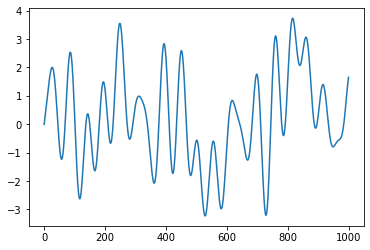

In [13]:
sim_length = 100*ms

np.random.seed(138)
Input_Signal = np.sin(np.arange(1000)*0.01)
for i in range(5):
    new_freq = np.sin(np.arange(1000)*np.random.normal(0,.1,1))
    Input_Signal += new_freq

plt.plot(Input_Signal)
#Use this signal for your LSM